# Modulation Classification
### Group 38: Kartik Kulgod, Young Li, Parker Martin

## Import Statements

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

## Define Neural Network

In [5]:
class ModulationClassifier(torch.nn.Module):
    def __init__(self, num_classes=11):
        super(ModulationClassifier, self).__init__()
        
        # Treating input as 2x128 image with 1 channel (depth 1)
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(1,3), padding=(0,2)), torch.nn.BatchNorm2d(256))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2,3), padding=(0,2)), torch.nn.BatchNorm2d(80))
        self.classifier = torch.nn.Sequential(torch.nn.Linear(in_features=10560, out_features=256),
                                              torch.nn.ReLU(True),
                                             torch.nn.Linear(in_features=256, out_features=11))

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y2 = F.relu(self.conv2(y1))
        y3 = torch.flatten(y2, 1)
        y4 = self.classifier(y3)
        return y4

## Setup Input Data

### Read data from file

In [6]:
fname = 'RML2016.10a_dict.pkl'
f = open(fname,'rb')

input_data_dict = pickle.load(f, encoding='latin1')

input_data_dict_keys = sorted(input_data_dict.keys())

modulation_types    = [input_data_dict_keys[i*20][0] for i in range(0,11)]
snr_types           = [input_data_dict_keys[i][1] for i in range(0,20)]

print(modulation_types)
print(snr_types)

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## Visualize Data

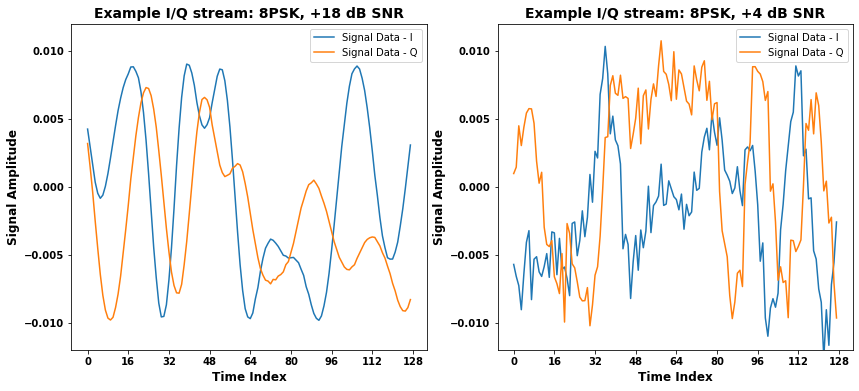

In [9]:
# Plot example I/Q timeseries
plt.figure(figsize=(14,6))

# Plot data 0 (out of range 0:999) of 8PSK, SNR +18
i_data = input_data_dict[('8PSK',18)][0][0]
q_data = input_data_dict[('8PSK',18)][0][1]

#### Fill in plot #####
plt.subplot(121)
plt.title('Example I/Q stream: 8PSK, +18 dB SNR', fontweight='bold', fontsize=14);
plt.plot(range(0,128), i_data, range(0,128), q_data);
plt.xlabel('Time Index', fontsize=12, fontweight='bold');
plt.xticks(np.arange(0, 129, step=16), fontweight='bold', fontsize=10);
plt.ylabel('Signal Amplitude', fontsize=12, fontweight='bold');
plt.yticks(fontweight='bold', fontsize=10);
plt.legend(('Signal Data - I','Signal Data - Q'), fontsize=10, loc=1);
plt.ylim(-.012, .012);

# Plot data 0 (out of range 0:999) of 8PSK, SNR +4
i_data = input_data_dict[('8PSK',4)][0][0]
q_data = input_data_dict[('8PSK',4)][0][1]

#### Fill in plot #####
plt.subplot(122)
plt.title('Example I/Q stream: 8PSK, +4 dB SNR', fontweight='bold', fontsize=14);
plt.plot(range(0,128), i_data, range(0,128), q_data);
plt.xlabel('Time Index', fontsize=12, fontweight='bold');
plt.xticks(np.arange(0, 129, step=16), fontweight='bold', fontsize=10);
plt.ylabel('Signal Amplitude', fontsize=12, fontweight='bold');
plt.yticks(fontweight='bold', fontsize=10);
plt.legend(('Signal Data - I','Signal Data - Q'), fontsize=10, loc=1);
plt.ylim(-.012, .012);
plt.show();

## Create Pytorch Dataset

In [10]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, X,Y,Z, transform=None):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        rX, rY, rZ = torch.unsqueeze(torch.from_numpy(self.X[idx]),dim=0).float(), torch.tensor(self.Y[idx]), torch.tensor(self.Z[idx])
        if(self.transform):
            rX, rY, rZ = self.transform(self.X[idx]),torch.tensor(self.Y[idx]),torch.tensor(self.Z[idx])
            
        return rX, rY, rZ

## Train with only positive SNR values

### Create data arrays

In [11]:
image_psnr = []
modulation_psnr = []
snr_psnr = []

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types[10:]:
        image_psnr.extend(input_data_dict[(m,s)])
        modulation_psnr.extend([m_cnt for _ in range(0,1000)])
        snr_psnr.extend([s for _ in range(0,1000)])
        
image_nsnr = []
modulation_nsnr = []
snr_nsnr = []

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types[:10]:
        image_nsnr.extend(input_data_dict[(m,s)])
        modulation_nsnr.extend([m_cnt for _ in range(0,1000)])
        snr_nsnr.extend([s for _ in range(0,1000)])
        
image_asnr = []
image_asnr.extend(image_psnr)
image_asnr.extend(image_nsnr)
modulation_asnr = []
modulation_asnr.extend(modulation_psnr)
modulation_asnr.extend(modulation_nsnr)
snr_asnr = []
snr_asnr.extend(snr_psnr)
snr_asnr.extend(snr_nsnr)
        
        
image_psnr = np.array(image_psnr)
modulation_psnr = np.array(modulation_psnr)
snr_psnr = np.array(snr_psnr)

image_nsnr = np.array(image_nsnr)
modulation_nsnr = np.array(modulation_nsnr)
snr_nsnr = np.array(snr_nsnr)

image_asnr = np.array(image_asnr)
modulation_asnr = np.array(modulation_asnr)
snr_asnr = np.array(snr_asnr)

print(len(image_asnr))

220000


# Create Dataloaders RUN ALL UP TO THIS ONE

In [12]:
transformed_dataset_psnr = myDataset(image_psnr, modulation_psnr, snr_psnr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))
transformed_dataset_nsnr = myDataset(image_nsnr, modulation_nsnr, snr_nsnr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))
transformed_dataset_asnr = myDataset(image_asnr, modulation_asnr, snr_asnr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))

l = list(range(0, 110000))
np.random.shuffle(l)
split = 0.5
train_indices_psnr, test_indices_psnr = l[:int(split*110000)],l[int(split*110000):]
test_indices_nsnr = l

l = list(range(0, 220000))
np.random.shuffle(l)
split = 0.5
train_indices_asnr, test_indices_asnr = l[:int(split*220000)],l[int(split*220000):]

train_sampler_psnr = torch.utils.data.SubsetRandomSampler(train_indices_psnr)
test_sampler_psnr  = torch.utils.data.SubsetRandomSampler(test_indices_psnr)
test_sampler_nsnr  = torch.utils.data.SubsetRandomSampler(test_indices_nsnr)

train_sampler_asnr = torch.utils.data.SubsetRandomSampler(train_indices_asnr)
test_sampler_asnr  = torch.utils.data.SubsetRandomSampler(test_indices_asnr)
#PSNR
trainloader_psnr   = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler_psnr, pin_memory=True)
testloader_psnr    = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler_psnr, pin_memory=True)
testloader_nsnr    = torch.utils.data.DataLoader(transformed_dataset_nsnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler_nsnr, pin_memory=True)

#ASNR
trainloader_asnr   = torch.utils.data.DataLoader(transformed_dataset_asnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler_asnr, pin_memory=True)
testloader_asnr    = torch.utils.data.DataLoader(transformed_dataset_asnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler_asnr, pin_memory=True)

## Intialize NN, Optimizer, Loss function

In [7]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

print(net)
for name, param in net.named_parameters():
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                          	torch.Size([80, 256, 2, 3])   	   

## Train NN

In [8]:
num_epochs = 50
epoch_loss_array = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    
    for i, data in enumerate(trainloader_psnr):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    print('Epoch {:d}, Training Loss {:f}'.format(epoch,running_loss/len(trainloader_psnr)))
    epoch_loss_array.append(running_loss/len(trainloader_psnr))

print('Finished Training')

Epoch 0, Training Loss 0.795499
Epoch 1, Training Loss 0.495227
Epoch 2, Training Loss 0.439237
Epoch 3, Training Loss 0.395535
Epoch 4, Training Loss 0.369175
Epoch 5, Training Loss 0.338165
Epoch 6, Training Loss 0.312121
Epoch 7, Training Loss 0.283148
Epoch 8, Training Loss 0.257490
Epoch 9, Training Loss 0.227101
Epoch 10, Training Loss 0.207913
Epoch 11, Training Loss 0.178198
Epoch 12, Training Loss 0.161253
Epoch 13, Training Loss 0.144218
Epoch 14, Training Loss 0.135054
Epoch 15, Training Loss 0.123659
Epoch 16, Training Loss 0.112880
Epoch 17, Training Loss 0.105294
Epoch 18, Training Loss 0.099423
Epoch 19, Training Loss 0.090580
Epoch 20, Training Loss 0.089180
Epoch 21, Training Loss 0.086165
Epoch 22, Training Loss 0.082080
Epoch 23, Training Loss 0.080959
Epoch 24, Training Loss 0.078669
Epoch 25, Training Loss 0.076261
Epoch 26, Training Loss 0.074711
Epoch 27, Training Loss 0.073854
Epoch 28, Training Loss 0.073370
Epoch 29, Training Loss 0.072808
Epoch 30, Training L

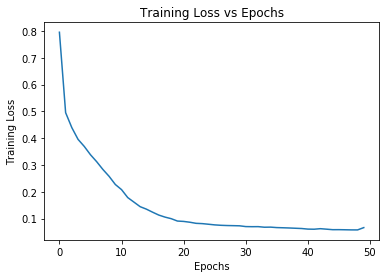

In [9]:
plt.plot(list(range(0,num_epochs)), epoch_loss_array)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.show()

## Test NN

In [10]:
PATH = './temp_model_psnr.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader_psnr):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

for i,data in enumerate(testloader_nsnr):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 37.086667 %


In [11]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
        print('SNR {:s} Accuracy {:f} %'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

SNR -20 Accuracy 9.045455 %
SNR -18 Accuracy 9.090909 %
SNR -16 Accuracy 9.109091 %
SNR -14 Accuracy 9.100000 %
SNR -12 Accuracy 9.236364 %
SNR -10 Accuracy 9.690909 %
SNR -8 Accuracy 11.027273 %
SNR -6 Accuracy 15.009091 %
SNR -4 Accuracy 26.027273 %
SNR -2 Accuracy 52.100000 %
SNR 0 Accuracy 71.520343 %
SNR 2 Accuracy 77.250229 %
SNR 4 Accuracy 79.644412 %
SNR 6 Accuracy 81.069364 %
SNR 8 Accuracy 80.716601 %
SNR 10 Accuracy 81.085526 %
SNR 12 Accuracy 80.675799 %
SNR 14 Accuracy 80.140403 %
SNR 16 Accuracy 81.069733 %
SNR 18 Accuracy 80.694419 %


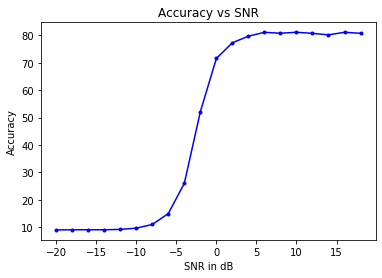

In [12]:
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy')
plt.title('Accuracy vs SNR')
plt.show()

## Train with all SNR values to see accuracy.  

## Intialize NN, Optimizer, Loss function

In [13]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(len(transformed_dataset_psnr))
print(len(trainloader_psnr))

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

print(net)
for name, param in net.named_parameters():
    #if param.requires_grad:
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

110000
430
cuda:0
ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                          	torch.Size([80, 

## Train NN

In [14]:
num_epochs = 50
epoch_loss_array = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    
    for i, data in enumerate(trainloader_asnr):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    print(running_loss/len(trainloader_asnr))
    epoch_loss_array.append(running_loss/len(trainloader_asnr))

print('Finished Training')

1.4858471505863722
1.2937767804362053
1.2317258193742397
1.1790891404761825
1.1263581289801488
1.0616162320209104
0.9921406226795774
0.9043277023836623
0.7985678465560425
0.6843555568609127
0.5535382823542107
0.4242558352129404
0.3196333116570184
0.23038927353052205
0.1667862384818321
0.12941525095943796
0.10887835466757763
0.08931274032003658
0.07441193802758705
0.06422909603909005
0.06567789705600156
0.05934579704216746
0.049694065918582817
0.044443975436652815
0.04103507632173078
0.03851637604624726
0.037416198576778865
0.03598408476709453
0.035443340254904226
0.03528761870206096
0.03617062963285418
0.03523782920958691
0.03345454211460513
0.034045992263181266
0.03233425709483929
0.03195768573083157
0.031083910258183644
0.030911121896446445
0.031084265585902125
0.032455535865453786
0.030292255667493093
0.029863233784711812
0.03086979260105033
0.039941278093516136
0.032200077444661496
0.029939810123137567
0.029310487316336568
0.028509596657267836
0.02883369304932827
0.0287222879137410

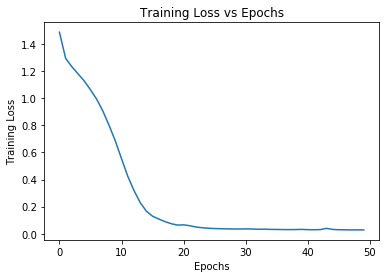

In [15]:
plt.plot(list(range(0,num_epochs)), epoch_loss_array)
plt.xlabel('Epochs'
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.show()

## Test NN

In [16]:
PATH = './temp_model_asnr.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader_asnr):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 48.663636 %


In [19]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

SNR -20 Accuracy 9.342749
SNR -18 Accuracy 9.268293
SNR -16 Accuracy 10.707837
SNR -14 Accuracy 11.884111
SNR -12 Accuracy 13.837272
SNR -10 Accuracy 18.093350
SNR -8 Accuracy 25.477360
SNR -6 Accuracy 34.537861
SNR -4 Accuracy 46.124454
SNR -2 Accuracy 57.551320
SNR 0 Accuracy 64.495294
SNR 2 Accuracy 71.399927
SNR 4 Accuracy 72.785040
SNR 6 Accuracy 73.135409
SNR 8 Accuracy 75.383505
SNR 10 Accuracy 76.111213
SNR 12 Accuracy 76.076040
SNR 14 Accuracy 75.374224
SNR 16 Accuracy 75.262093
SNR 18 Accuracy 77.341335


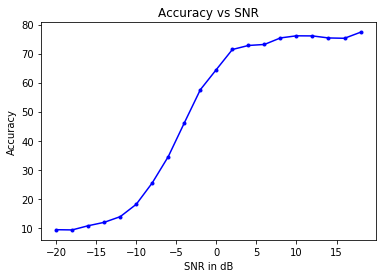

In [20]:
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy')
plt.title('Accuracy vs SNR')
plt.show()

### Above we have discussed that having -SNR values in our model will hinder our accuracy and we have shown that that is true.


### Now, lets try to setup a validation set and do some hyperparameter tuning.


### Define some data loaders

In [21]:
dataset_len = 110000
l = list(range(0, dataset_len))
np.random.shuffle(l)

split = 0.7
train_indices, test_indices = l[:int(split*dataset_len)], l[int(split*dataset_len):]

valsplit = 0.5
test_indices, val_indices = test_indices[:int(valsplit*len(test_indices))], test_indices[int(valsplit*len(test_indices)):]

print(len(train_indices), len(test_indices),len(val_indices))

train_sampler=torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler=torch.utils.data.SubsetRandomSampler(test_indices)
val_sampler=torch.utils.data.SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler, pin_memory=True)
valloader   = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=val_sampler, pin_memory=True)
testloader1 = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler, pin_memory=True)
testloader2 = torch.utils.data.DataLoader(transformed_dataset_nsnr, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

77000 16500 16500


## Intialize NN, Optimizer, Loss function

In [22]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

print(net)
for name, param in net.named_parameters():
    #if param.requires_grad:
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

cuda:0
ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                          	torch.Size([80, 256, 2, 3])

## Train NN RUN VALIDATION_FUNCTION CODE

In [19]:
def validation_function(net, criterion):
    PATH = './temp_model_val.pth'
    torch.save(net.state_dict(), PATH) 

    model1 = ModulationClassifier()
    model1.to(device)
    model1.load_state_dict(torch.load(PATH))
    
    val_loss = 0
    total = 0
    model1.eval()
    for i, data in enumerate(valloader):
        xv, yv, zv = data
        xv, yv, zv = xv.to(device), yv.to(device), zv.to(device)

        yv_pred = model1.forward(xv)
        batchv_loss = criterion(yv_pred, yv.long())
        val_loss += batchv_loss.item()

        total += 128
        
    #print(val_loss)
        
    return val_loss

In [24]:
num_epochs = 25
epoch_loss_array = np.zeros(num_epochs)

historyEpoch = []
historyLoss = []
historyValLoss = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    correct_test = 0
    historyEpoch.append(epoch)
    
    for i, data in enumerate(trainloader):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        correct_test += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        #print(y_pred)
        #print(loss.item())
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    valloss = validation_function(net, criterion)
    print("Epoch #", epoch, 'Correct:', correct_test,"Loss: ", running_loss/len(trainloader), 'Val Loss', valloss/len(valloader))
    historyLoss.append(running_loss/len(trainloader))
    historyValLoss.append(valloss/len(valloader))

print('Finished Training')
plt.show()

Epoch # 0 Correct: 52019 Loss:  0.7266184337115367 Val Loss 0.495158359985943
Epoch # 1 Correct: 58803 Loss:  0.4777711737789585 Val Loss 0.43913901706998665
Epoch # 2 Correct: 60830 Loss:  0.41577478253168126 Val Loss 0.42862019728320516
Epoch # 3 Correct: 62043 Loss:  0.38227404309962676 Val Loss 0.39709701880004056
Epoch # 4 Correct: 63084 Loss:  0.3546463265965547 Val Loss 0.3881848392098449
Epoch # 5 Correct: 64234 Loss:  0.32798779305330544 Val Loss 0.38757530986800676
Epoch # 6 Correct: 65337 Loss:  0.30130171327792926 Val Loss 0.4086051340713057
Epoch # 7 Correct: 66399 Loss:  0.2762696513305867 Val Loss 0.4209156999754351
Epoch # 8 Correct: 67324 Loss:  0.2510707755619505 Val Loss 0.44669188778529795
Epoch # 9 Correct: 68380 Loss:  0.22630051353890634 Val Loss 0.43747128188148027
Epoch # 10 Correct: 69251 Loss:  0.2031631961687657 Val Loss 0.45443264343017753
Epoch # 11 Correct: 70098 Loss:  0.1840161551099481 Val Loss 0.48906322643738387
Epoch # 12 Correct: 70709 Loss:  0.166

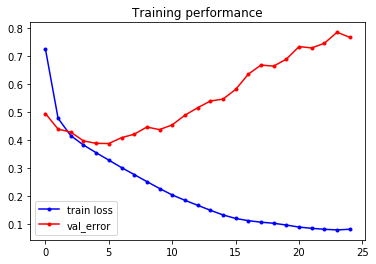

In [26]:
plt.figure()
plt.title('Training performance')
plt.plot(historyEpoch, historyLoss, 'b.-',label='train loss')
plt.plot(historyEpoch, historyValLoss,'r.-', label='val_error')
plt.legend()

## Test NN

In [27]:
PATH = './temp_model_new.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader1):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

for i,data in enumerate(testloader2):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

print('%d %d Accuracy of the network on the test images: %f %%' % (correct, total,
    100 * correct / total))

31419 126500 Accuracy of the network on the test images: 24.837154 %


In [28]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

SNR -20 Accuracy 9.136364
SNR -18 Accuracy 9.027273
SNR -16 Accuracy 9.018182
SNR -14 Accuracy 9.100000
SNR -12 Accuracy 9.154545
SNR -10 Accuracy 9.309091
SNR -8 Accuracy 10.409091
SNR -6 Accuracy 14.472727
SNR -4 Accuracy 27.300000
SNR -2 Accuracy 57.672727
SNR 0 Accuracy 75.057078
SNR 2 Accuracy 79.573171
SNR 4 Accuracy 81.386633
SNR 6 Accuracy 81.985294
SNR 8 Accuracy 80.272512
SNR 10 Accuracy 82.123246
SNR 12 Accuracy 80.645161
SNR 14 Accuracy 81.818182
SNR 16 Accuracy 81.146026
SNR 18 Accuracy 83.215548


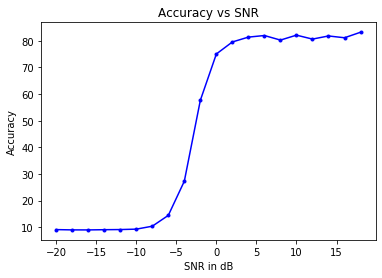

In [29]:
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy')
plt.title('Accuracy vs SNR')
plt.show()

### Add dropout layer NOW EVERYTHING BELOW CAN BE RAN
Start by adding 50% dropout after the two convolutional layers.

In [15]:
class ModulationClassifier(torch.nn.Module):
    def __init__(self, num_classes=11):
        super(ModulationClassifier, self).__init__()
        
        # Treating input as 2x128 image with 1 channel (depth 1)
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(1,3), padding=(0,2)), torch.nn.BatchNorm2d(256))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2,3), padding=(0,2)), torch.nn.BatchNorm2d(80))
        self.drop1 = torch.nn.Dropout(0.50)
        self.classifier = torch.nn.Sequential(torch.nn.Linear(in_features=10560, out_features=256),
                                              torch.nn.ReLU(True),
                                             torch.nn.Linear(in_features=256, out_features=11))

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y2 = self.drop1(y1)
        y3 = F.relu(self.conv2(y2))
        y4 = self.drop1(y3)
        y5 = torch.flatten(y4, 1)
        y6 = self.drop1(y5)
        y7 = self.classifier(y6)
        return y7

# These next couple of boxes are going to be dedicated to hyperparameter tuning. 
Set up same dataloaders.

In [16]:
dataset_len = 110000
l = list(range(0, dataset_len))
np.random.shuffle(l)

split = 0.7
train_indices, test_indices = l[:int(split*dataset_len)], l[int(split*dataset_len):]

valsplit = 0.5
test_indices, val_indices = test_indices[:int(valsplit*len(test_indices))], test_indices[int(valsplit*len(test_indices)):]

print(len(train_indices), len(test_indices),len(val_indices))

train_sampler=torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler=torch.utils.data.SubsetRandomSampler(test_indices)
val_sampler=torch.utils.data.SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler, pin_memory=True)
valloader   = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=val_sampler, pin_memory=True)
testloader1 = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler, pin_memory=True)
testloader2 = torch.utils.data.DataLoader(transformed_dataset_nsnr, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

77000 16500 16500


In [17]:
net = ModulationClassifier()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

print(net)
for name, param in net.named_parameters():
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop1): Dropout(p=0.55, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                   

In [20]:
num_epochs = 100
epoch_loss_array = np.zeros(num_epochs)

historyEpoch = []
historyLoss = []
historyValLoss = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    correct_test = 0
    historyEpoch.append(epoch)
    
    for i, data in enumerate(trainloader):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        correct_test += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        #print(y_pred)
        #print(loss.item())
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    valloss = validation_function(net, criterion)
    print("Epoch #", epoch, 'Correct:', correct_test,"Loss: ", running_loss/len(trainloader), 'Val Loss', valloss/len(valloader))
    historyLoss.append(running_loss/len(trainloader))
    historyValLoss.append(valloss/len(valloader))

print('Finished Training')
plt.show()

Epoch # 0 Correct: 45589 Loss:  0.9756714695711864 Val Loss 0.7508750470109689
Epoch # 1 Correct: 50737 Loss:  0.7649683718665494 Val Loss 0.6317484147788942
Epoch # 2 Correct: 52539 Loss:  0.6874688294440805 Val Loss 0.5897532043068908
Epoch # 3 Correct: 53262 Loss:  0.6504889332574864 Val Loss 0.5605626891749774
Epoch # 4 Correct: 54089 Loss:  0.6221636321358507 Val Loss 0.5423311565735544
Epoch # 5 Correct: 54724 Loss:  0.6012711394763864 Val Loss 0.5132206978723984
Epoch # 6 Correct: 55507 Loss:  0.5748406370909903 Val Loss 0.491771505553593
Epoch # 7 Correct: 56431 Loss:  0.5537885019054445 Val Loss 0.4775433794472569
Epoch # 8 Correct: 56923 Loss:  0.5364904406161799 Val Loss 0.46863544564838555
Epoch # 9 Correct: 57484 Loss:  0.5223812183173392 Val Loss 0.4514371468577274
Epoch # 10 Correct: 57705 Loss:  0.5175874741667529 Val Loss 0.4439548672169678
Epoch # 11 Correct: 58023 Loss:  0.504987567118632 Val Loss 0.44223571609157003
Epoch # 12 Correct: 58437 Loss:  0.496076292670842

## Plot

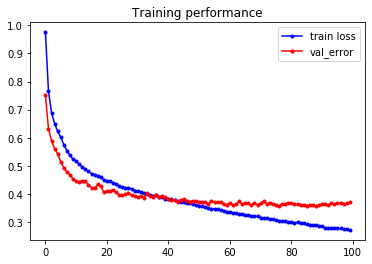

In [21]:
plt.figure()
plt.title('Training performance')
plt.plot(historyEpoch, historyLoss, 'b.-',label='train loss')
plt.plot(historyEpoch, historyValLoss,'r.-', label='val_error')
plt.legend()

## Test NN (This set has dropout)

In [22]:
PATH = './temp_model_new.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader1):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

for i,data in enumerate(testloader2):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

print('%d %d Accuracy of the network on the test images: %f %%' % (correct, total,
    100 * correct / total))

31903 126500 Accuracy of the network on the test images: 25.219763 %


In [23]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

SNR -20 Accuracy 9.090909
SNR -18 Accuracy 9.090909
SNR -16 Accuracy 9.090909
SNR -14 Accuracy 9.090909
SNR -12 Accuracy 9.090909
SNR -10 Accuracy 9.100000
SNR -8 Accuracy 9.281818
SNR -6 Accuracy 10.990909
SNR -4 Accuracy 25.527273
SNR -2 Accuracy 66.763636
SNR 0 Accuracy 79.619048
SNR 2 Accuracy 81.998796
SNR 4 Accuracy 82.352941
SNR 6 Accuracy 81.393902
SNR 8 Accuracy 82.027930
SNR 10 Accuracy 82.327318
SNR 12 Accuracy 83.545841
SNR 14 Accuracy 82.514970
SNR 16 Accuracy 81.093936
SNR 18 Accuracy 82.394784


## Create a dataframe with results of model with certain hyperparameters.

In [13]:
import pandas as pd

In [26]:
lr = [0.01, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.005, 0.001] #learning rate
opt = ["SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD"] #optimizer used
acc = [24.458, 24.587, 25.315, 24.500, 25.283, 24.932, 23.896, 24.552, 24.659, 25.220] #accuracy of all
dropout = ["yes, 1 layer 50%", "yes, 3 layers 50%", "yes, 3 layers 50%", "yes 3 layers 50%", "yes 3 layers 60%", "yes 3 layers 60%","yes 3 layers 70%", "yes 3 layers 70%","yes 3 layers 70%", "yes 3 layers 55%" ] #was dropout used?
ec = [25, 25, 100, 43, 100, 150, 100, 150, 100, 100] #epoch count

df = pd.DataFrame(list(zip(lr, opt, acc, dropout, ec)), columns =['Learning Rate', 'Optimizer', 'Accuracy', 'Dropout', 'Num Epochs'])


df.head(9)

,Learning Rate,Optimizer,Accuracy,Dropout,Num Epochs
0,0.010,SGD,24.458,"yes, 1 layer 50%",25
1,0.001,SGD,24.587,"yes, 3 layers 50%",25
2,0.001,SGD,25.315,"yes, 3 layers 50%",100
3,0.001,SGD,24.500,yes 3 layers 50%,43
4,0.001,SGD,25.283,yes 3 layers 60%,100
5,0.001,SGD,24.932,yes 3 layers 60%,150
6,0.001,SGD,23.896,yes 3 layers 70%,100
7,0.001,SGD,24.552,yes 3 layers 70%,150
8,0.005,SGD,24.659,yes 3 layers 70%,100


The motivation on line 3 for 43 epochs is because on line 2, the data started overfitting after 40ish epochs.


Conv layers are untouched.
Momentum = 0.9 for all of these.
SGD Optimizer for all of these.